In [1]:
import glob
import numpy  as np
import tables as tb
import matplotlib.pyplot as plt


from invisible_cities.database import load_db


from invisible_cities.reco.corrections_new import read_maps
from invisible_cities.reco.corrections_new import apply_all_correction
from invisible_cities.reco.corrections_new import norm_strategy

In [2]:
# SELECT PMAPS
run = 7600
pmaps_dir = f"/home/gdiaz/IRENE_NOTEBOOKS/DATA/pmaps/{run}/trigger1/"

pmaps_files = glob.glob( pmaps_dir + "/*" )
pmaps_files.sort()

# SIPMs DATA
datasipm = load_db.DataSiPM("new", run)
all_sipms = datasipm.index.get_values()

X = datasipm["X"].values
Y = datasipm["Y"].values

# CORRECTION MAP
maps = read_maps("/home/gdiaz/IRENE_NOTEBOOKS/DATA/maps/map_7600.h5")
total_correction = apply_all_correction(maps, apply_temp=True)
#                                         norm_strat=norm_strategy.custom,
#                                         norm_value=10)

In [3]:
file_number = 0

pmaps = tb.open_file( pmaps_files[file_number] )
S1   = pmaps.root.PMAPS.S1  .read()
S2   = pmaps.root.PMAPS.S2  .read()
S2Si = pmaps.root.PMAPS.S2Si.read()
event_times = pmaps.root.Run.events.read()

In [4]:
#Choose event and peak
event_time = event_times[ np.random.randint(len(event_times)) ]

# CUT 1S1 1S2
s1pks = len( np.unique(S1[ S1["event"]==event_time[0] ]["peak"] ) )
s2pks = len( np.unique(S2[ S2["event"]==event_time[0] ]["peak"] ) )

if (s1pks == 1) & (s2pks == 1):
    
    s1pk = 0
    s2pk = 0
    
    
    # SELECT S1 WAVEFORM
    sel = (S1["event"]==event_time[0]) & (S1["peak"]==s1pk)
    s1_times = S1[sel]["time"]/1000
    s1_ene   = S1[sel]["ene"]
    S1_time = np.sum( s1_times * s1_ene ) / np.sum(s1_ene) 


    # SELECT S2 PMT WAVEFORM 
    sel = (S2["event"]==event_time[0]) & (S2["peak"]==s2pk)
    s2_times = S2[sel]["time"]/1000

    s2_pmt = S2[sel]["ene"] #/ np.sum(S2[sel]["ene"]*1)


    # SELECT  S2 SIPMS WAVEFORM
    sel = (S2Si["event"]==event_time[0])&(S2Si["peak"]==s2pk)
    sipms, idxs = np.unique(S2Si[sel]["nsipm"], return_index=True)
    sipm_wfs    = np.array( np.split(S2Si[sel], idxs[1:]) )

    s2_sipms = sipm_wfs["ene"]

else:
    print("Event do not pass the cut")

In [5]:
Zs = (s2_times-S1_time)/10

assert s2_sipms.shape[1]==Zs.shape[0]

In [6]:
E = []

for slide, z in enumerate(Zs):
    sel_sipms = np.isin(all_sipms, sipms)
    
    Z = np.full(s2_sipms.shape[0], Zs[slide])
    T = np.full(s2_sipms.shape[0], event_time[1])

    corr_tot = total_correction(X[sel_sipms], Y[sel_sipms], Z, T)
    correction_factor = np.where(~np.isnan(corr_tot), corr_tot, 0)
    
    qi = s2_sipms[:, slide]
    Ecorrected = s2_pmt[slide] * np.sum( qi / np.sum(qi) * correction_factor )
    
    E.append(Ecorrected)
E = np.array(E)

/home/gdiaz/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


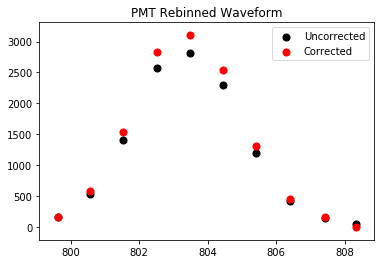

In [7]:
plt.scatter(s2_times, s2_pmt, c="black", s=50, label="Uncorrected")

E = np.where(~np.isnan(E), E, 0)
plt.scatter(s2_times, E, c="r", s=50, label="Corrected" )

plt.legend()
plt.title("PMT Rebinned Waveform");